In [ ]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm
from lightgbm import LGBMClassifier
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1)

In [3]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [4]:
train_df = reduce_mem_usage(pd.read_csv("Featured_train.csv"))

Memory usage of dataframe is 4086.12MB
Memory usage after optimization is: 988.93MB
Decreased by 75.8%


In [6]:
train_df.columns

Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event', 'fp1_f7',
       'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3', 'c3_p3', 'p3_o1', 'fz_cz',
       'cz_pz', 'pz_poz', 'fp2_f8', 'f8_t4', 't4_t6', 't6_o2', 'fp2_f4',
       'f4_c4', 'c4_p4', 'p4_o2'],
      dtype='object')

## Features

We are removing **time** and **experiment** for model training. Because as we have seen in EDA part Time and Experiment are completely different from Test data set   

In [11]:
features=['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr','fp1_f7',
       'f7_t3', 't3_t5', 't5_o1', 'fp1_f3', 'f3_c3', 'c3_p3', 'p3_o1', 'fz_cz',
       'cz_pz', 'pz_poz', 'fp2_f8', 'f8_t4', 't4_t6', 't6_o2', 'fp2_f4',
       'f4_c4', 'c4_p4', 'p4_o2']

In [12]:
len(features)

44

In [16]:
train_df[features].head()

,crew,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
0,1,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,23.718750,-6.695312,...,-7.871094,-15.281250,2.832031,3.265625,-29.515625,2.210938,-9.789062,-34.281250,19.937500,2.929688
1,1,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,21.015625,-6.476562,...,-4.136719,-14.218750,2.849609,-5.566406,-19.718750,-1.781250,-13.578125,-24.062500,11.773438,1.649414
2,1,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,25.437500,-0.088684,...,-7.039062,-14.593750,-15.437500,-9.375000,8.578125,-6.105469,-12.796875,24.718750,-31.406250,-2.851562
3,1,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,19.140625,-0.256592,...,-6.097656,-14.000000,-2.689453,-9.976562,-8.117188,1.535156,-11.718750,-7.113281,-4.582031,4.156250
4,1,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,20.578125,-1.953125,...,-10.796875,-10.171875,-2.066406,-5.632812,-14.085938,-2.978516,-9.960938,1.452148,-16.203125,-0.058105


In [16]:
sample = train_df.groupby('event', group_keys=False).apply(lambda train_df: train_df.sample(500000))
sample.shape
# sample_y = sample['event']
# sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)


(2000000, 45)

In [17]:
sample.to_csv("20L_Sample.csv",index=False)

In [5]:
y_true = train_df['event']
train_df.drop(columns=['event','experiment','time'],inplace=True)

In [8]:
y_true = y_true.astype(int)
print(y_true[:5])

0    1
1    1
2    1
3    1
4    1
Name: event, dtype: int64


In [12]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('crew') and  str(feature_name) != str('experiment') and str(feature_name) != str('time')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
norm_df = normalize(train_df_optimize)


In [13]:
norm_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
0,1,1,0.011719,1.0,0.406982,0.443115,0.431152,0.463135,0.583496,0.531738,...,0.427246,0.548340,0.430908,0.450439,0.471436,0.711426,0.410400,0.523438,0.475342,0.732422
1,1,1,0.015625,1.0,0.407959,0.443604,0.431396,0.465820,0.583008,0.530273,...,0.427979,0.548828,0.430908,0.447754,0.474854,0.710449,0.409424,0.525879,0.467041,0.732422
2,1,1,0.019531,1.0,0.411865,0.444092,0.437744,0.474854,0.583008,0.531250,...,0.427246,0.548828,0.425293,0.447021,0.485352,0.708984,0.409912,0.536621,0.424316,0.731445
3,1,1,0.023438,1.0,0.411865,0.442871,0.434326,0.470703,0.585449,0.531250,...,0.427490,0.548828,0.428955,0.446533,0.479248,0.711426,0.409912,0.529297,0.450928,0.732910
4,1,1,0.027344,1.0,0.410645,0.442871,0.433838,0.468994,0.584961,0.529785,...,0.426758,0.549805,0.429199,0.447754,0.477051,0.710449,0.410400,0.531738,0.439453,0.731934


In [6]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(train_df, y_true,stratify=y_true,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [7]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in CV data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7292950, 44)
Number of data points in CV data : (1823238, 44)
Number of data points in test data : (2279048, 44)


In [8]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points {} %".format((len(test_y)-np.trace(C))/len(test_y)*100))
    # C = 4,4 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1.0,2.0,3.0,4.0]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,6))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,6))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,6))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [23]:
start_mem = X_train.memory_usage().sum() / 1024**2
print(('Memory usage of dataframe is {:.2f}''MB').format(start_mem))

Memory usage of dataframe is 653.78MB


In [24]:
y_train.unique()

array([4., 2., 3., 1.], dtype=float16)

# Random Model

Log loss on Test Data using Random Model 1.6449793767878684
Number of misclassified points  74.95269954823242
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


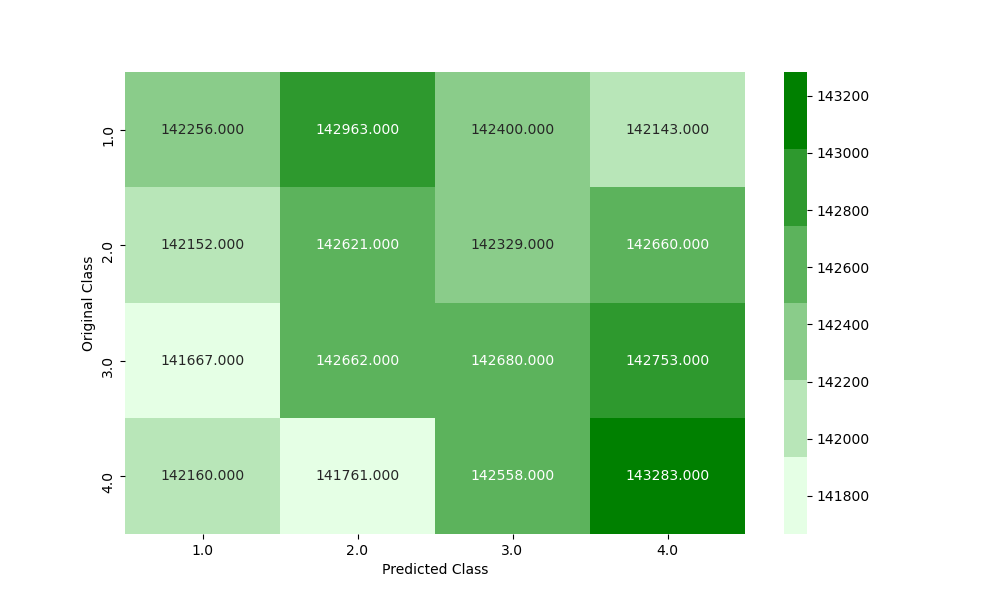

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


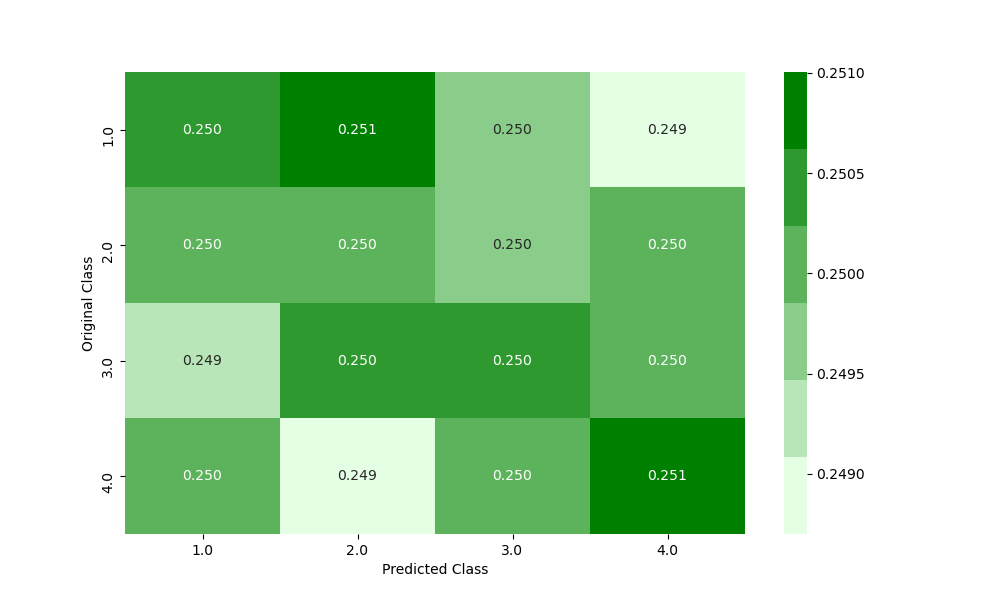

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


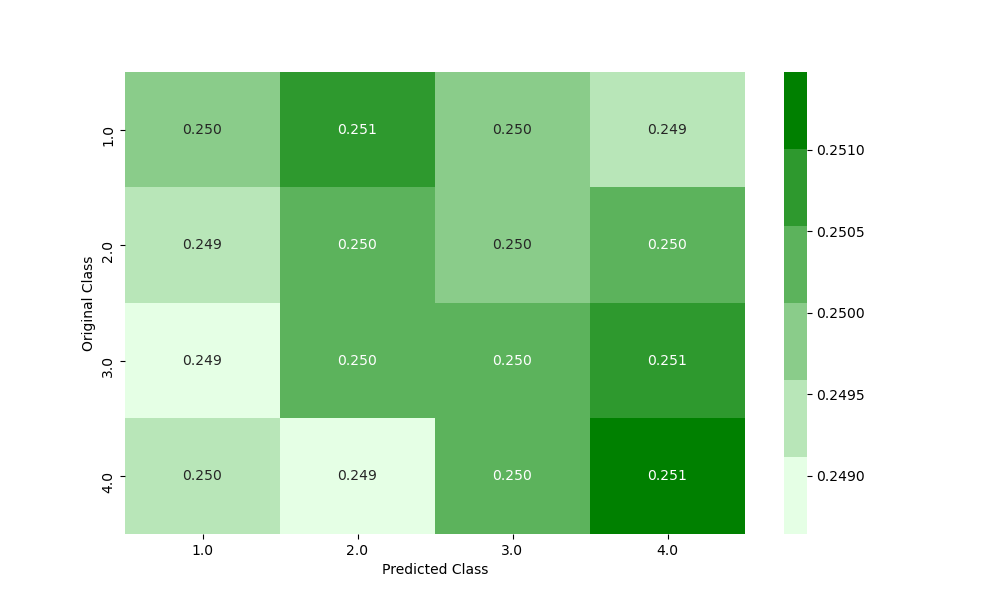

Sum of rows in precision matrix [1. 1. 1. 1.]


In [15]:
predicted_y = np.zeros((len(y_test),4))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,4)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)


# Logistic Regression

log_loss for c =  1e-05 is 1.3741484241201571
log_loss for c =  0.0001 is 1.3744214537775565
log_loss for c =  0.001 is 1.374379272770913
log_loss for c =  0.01 is 1.3759470334659123
log_loss for c =  0.1 is 1.3734429054671993
log_loss for c =  1 is 1.3747668622803793
log_loss for c =  10 is 1.3754222184782652
log_loss for c =  100 is 1.3764782205920327
log_loss for c =  1000 is 1.3746150982651475


<IPython.core.display.Javascript object>


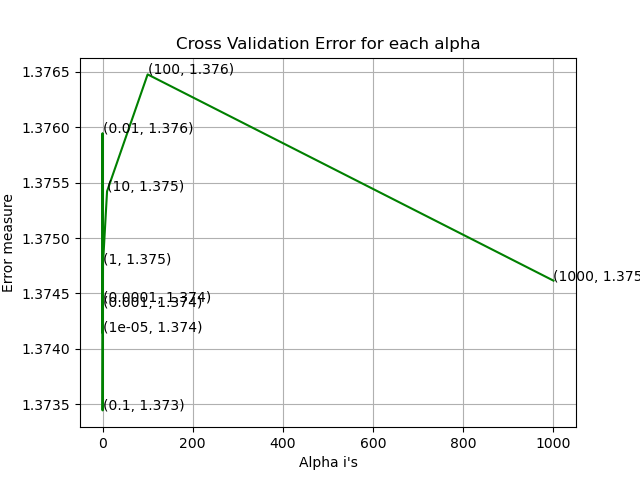

In [26]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    data = pd.concat([X_train, y_train], axis=1, sort=False)
    sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(50000))
    sample_y = sample['event']
    sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)
    
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(sample_X_train,sample_y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(sample_X_train, sample_y_train)
    predict_y = sig_clf.predict_proba(sample_X_cv)
    cv_log_error_array.append(log_loss(sample_y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    del data,sample,sample_y,sample_X_train, sample_X_cv, sample_y_train, sample_y_cv
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [27]:
print("Using HyperParameter we found best Alpha is : ",alpha[best_alpha])

Using HyperParameter we found best Alpha is :  0.1


log loss for train data 1.374276970545159
log loss for cv data 1.374531284474219
log loss for test data 1.374282742707717
Number of misclassified points 70.66511982196076 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


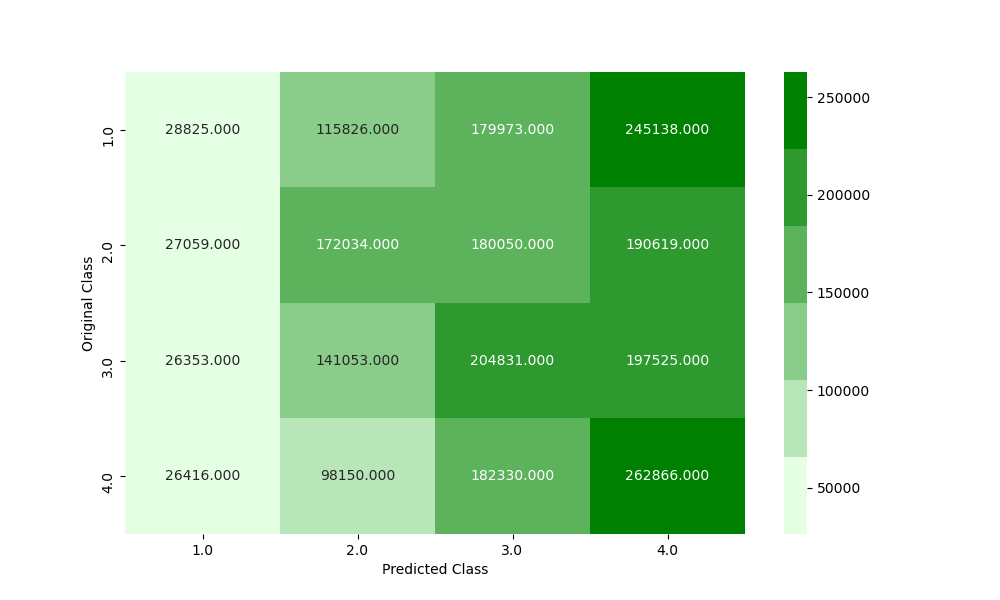

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


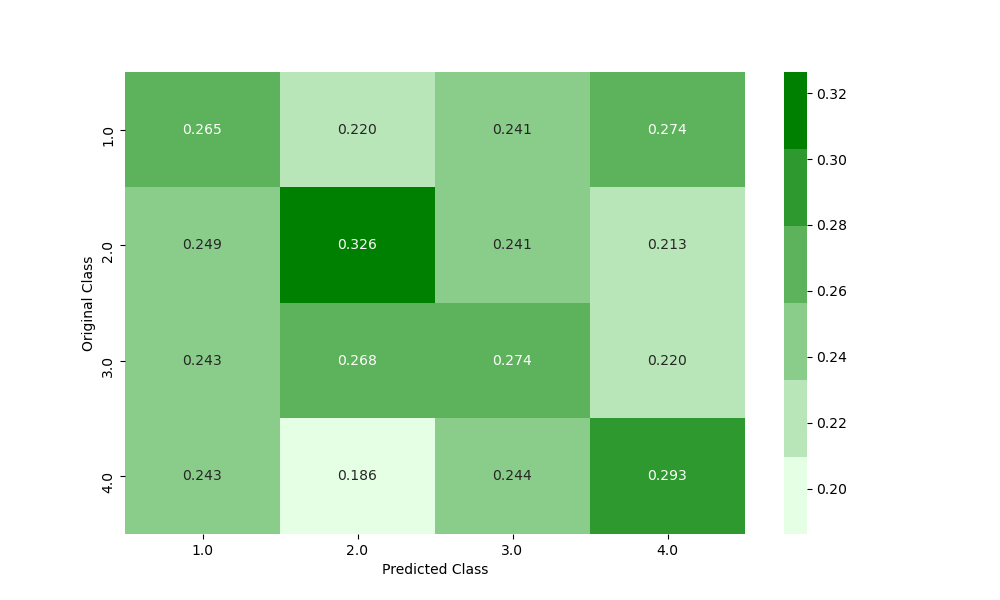

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


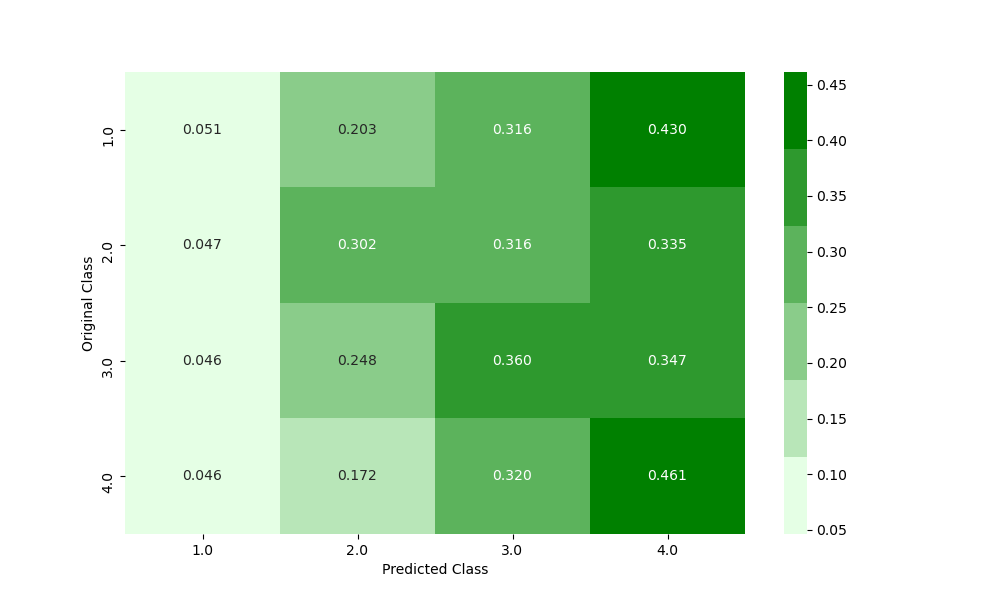

Sum of rows in precision matrix [1. 1. 1. 1.]
CPU times: user 14min 43s, sys: 23.9 s, total: 15min 7s
Wall time: 2min 21s


In [29]:
%%time
data = pd.concat([X_train, y_train], axis=1, sort=False)
sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(100000))
sample_y = sample['event']
sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(sample_X_train,sample_y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(sample_X_train,sample_y_train)


predict_y = sig_clf.predict_proba(sample_X_train)
print ('log loss for train data',log_loss(sample_y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y_test=sig_clf.predict(X_test)
plot_confusion_matrix(y_test,predict_y_test)
##-----------------Saving Model---------------------------##
filename = 'logistic_regression_model_002.sav'
pickle.dump(sig_clf, open(filename, 'wb'))

In [31]:
cv_log_error_array

[0.10551218447909964, 0.10140332193251828]

In [33]:
del sig_clf,r_cfl

# Random Forest

In [ ]:
alpha=[100,500,800,1000,1500]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
count=0
for i in alpha:
    data = pd.concat([X_train, y_train], axis=1, sort=False)
    sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(100000))
    sample_y = sample['event']
    sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(sample_X_train,sample_y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(sample_X_train,sample_y_train)
    predict_y = sig_clf.predict_proba(sample_X_cv)
    cv_log_error_array.append(log_loss(sample_y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))
    print("Alpha Value {}  : log loss is {}" .format(i,cv_log_error_array[count]))
    count +=1
    del r_cfl,sig_clf,data,sample,sample_y,sample_X_train, sample_X_cv, sample_y_train, sample_y_cv

# for i in range(len(cv_log_error_array)):
#     print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

Alpha Value 100  : log loss is 0.14995257142478163
Alpha Value 500  : log loss is 0.14552133925388644
Alpha Value 800  : log loss is 0.14301221374286624
Alpha Value 1000  : log loss is 0.1439456099454


In [14]:
print("Best Base learning is {}".format(alpha[best_alpha]))

Best Base learning is 800


In [9]:
alpha= [800]
best_alpha=0
alpha[best_alpha]

800

For values of best alpha =  800 The train log loss is: 0.022682029703371118
For values of best alpha =  800 The cross validation log loss is: 0.1452738581201923
For values of best alpha =  800 The test log loss is: 0.14471630669132446
Number of misclassified points 5.6199781663220785 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


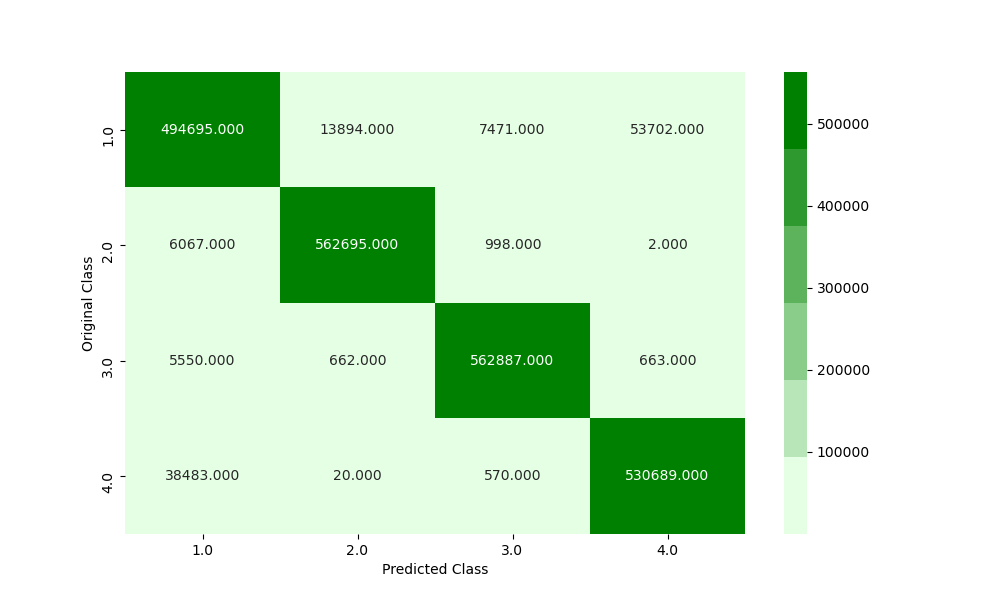

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


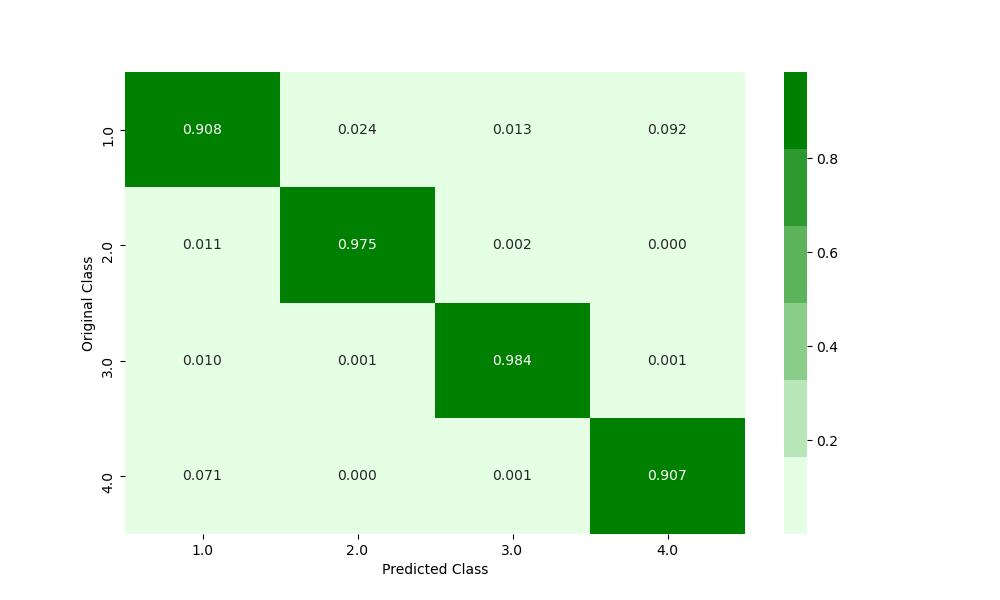

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


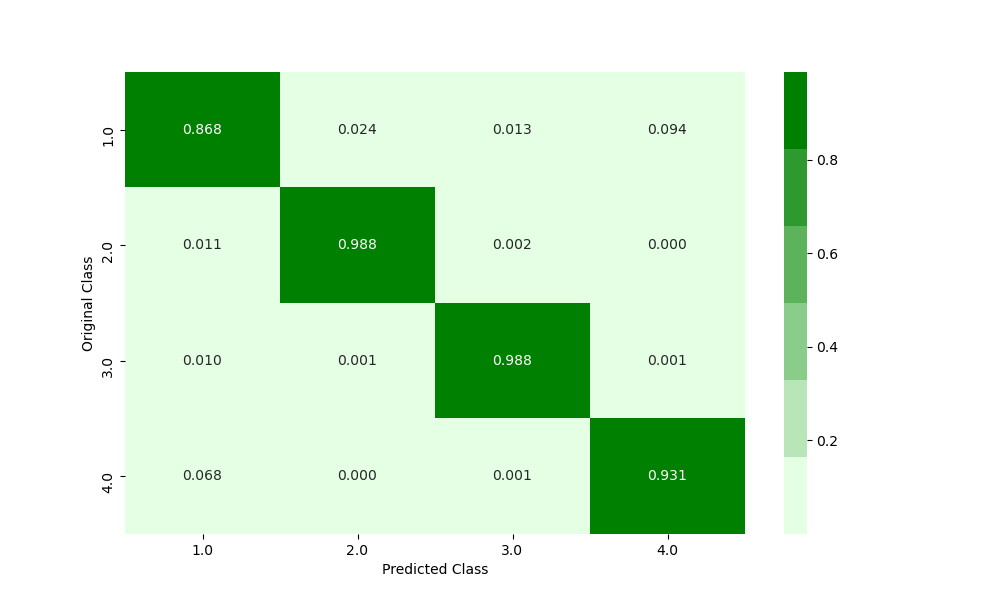

Sum of rows in precision matrix [1. 1. 1. 1.]


In [10]:
data = pd.concat([X_train, y_train], axis=1, sort=False)
sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(100000))
sample_y = sample['event']
sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(sample_X_train,sample_y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(sample_X_train,sample_y_train)

predict_y = sig_clf.predict_proba(sample_X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(sample_y_train, predict_y))
predict_y = sig_clf.predict_proba(sample_X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(sample_y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [11]:
# filename = 'main_Random_Forest_model_without_time_.sav'
# pickle.dump(r_cfl, open(filename, 'wb'))

filename = 'Random_Forest_model_without_time_ccc.sav'
pickle.dump(sig_clf, open(filename, 'wb'))

In [9]:
filename="main_Random_Forest_model_without_time_.sav"
r_cfl = pickle.load(open(filename, 'rb'))

In [10]:
data = pd.concat([X_train, y_train], axis=1, sort=False)
sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(100000))
sample_y = sample['event']
sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)
# r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
# r_cfl.fit(sample_X_train,sample_y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(sample_X_train,sample_y_train)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=800,
                                                             n_jobs=-1,
                                                             random_state=42))

In [17]:
##-----------------Saving Model---------------------------##
filename = 'Random_Forest_model_003.sav'
pickle.dump(sig_clf, open(filename, 'wb'))

# LightGBM

In [8]:
from lightgbm import LGBMClassifier
x_cfl=LGBMClassifier()

prams={
    'learning_rate':[0.01,0.05,0.1,0.15],
     'n_estimators':[100,200,500,1000,1500],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.1,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
data = pd.concat([X_train, y_train], axis=1, sort=False)
sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(200000))
sample_y = sample['event']
sample_X_train, sample_X_cv, sample_y_train, sample_y_cv = train_test_split(sample.drop(['event'],axis=1), sample_y,stratify=sample_y,test_size=0.20)
random_cfl.fit(sample_X_train, sample_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 15.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 20.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 21.9min finished


RandomizedSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         1500],
                                        'subsample': [0.1, 0.5, 1]},
                   verbose=10)

In [10]:
random_cfl.best_params_

{'subsample': 0.1,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [12]:
subsample = random_cfl.best_params_['subsample']
n_estimators=  random_cfl.best_params_['n_estimators']
max_depth =  random_cfl.best_params_['max_depth']
learning_rate =  random_cfl.best_params_['learning_rate']
colsample_bytree =  random_cfl.best_params_['colsample_bytree']


In [ ]:
filename="Models/main_LightGBM_model_003.sav"
x_cfl = pickle.load(open(filename, 'rb'))

filename1="Models/LightGBM_model_003.sav"
c_cfl = pickle.load(open(filename1, 'rb'))

train loss 0.13323679228467541
cv loss 0.133072257828121
test loss 0.1360609289345851
Number of misclassified points 5.232886714101678 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


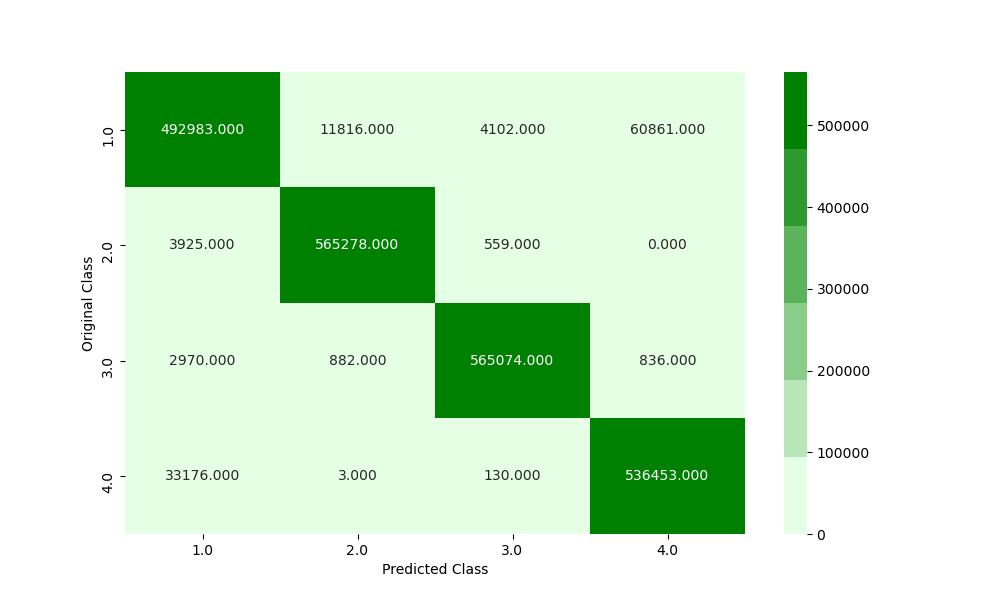

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


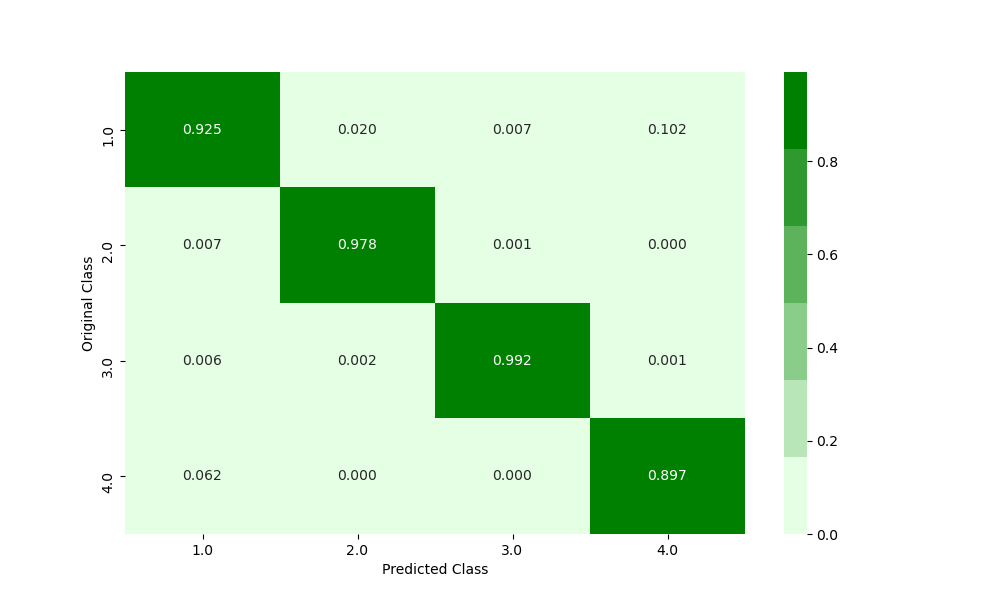

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


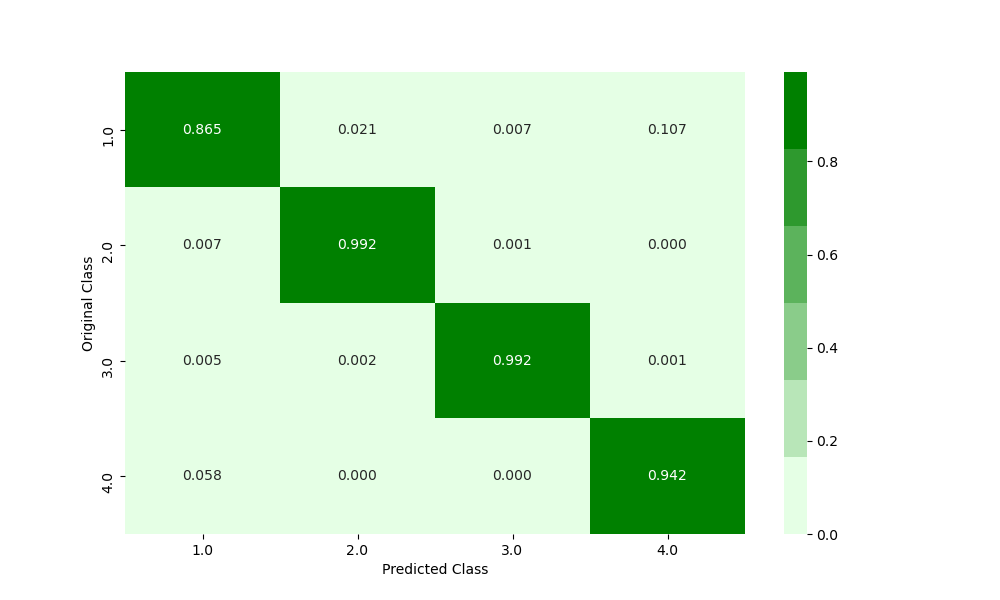

Sum of rows in precision matrix [1. 1. 1. 1.]


In [10]:
x_cfl=LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree= colsample_bytree, max_depth=max_depth,subsample=subsample,n_jobs=-1,)
x_cfl.fit(X_train,y_train)

c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, c_cfl.predict(X_test))

In [23]:
##-----------------Saving Model---------------------------##
filename = 'Lightlgb_model_003.sav'
pickle.dump(c_cfl, open(filename, 'wb'))

Important Feature Using LightGBM

<IPython.core.display.Javascript object>


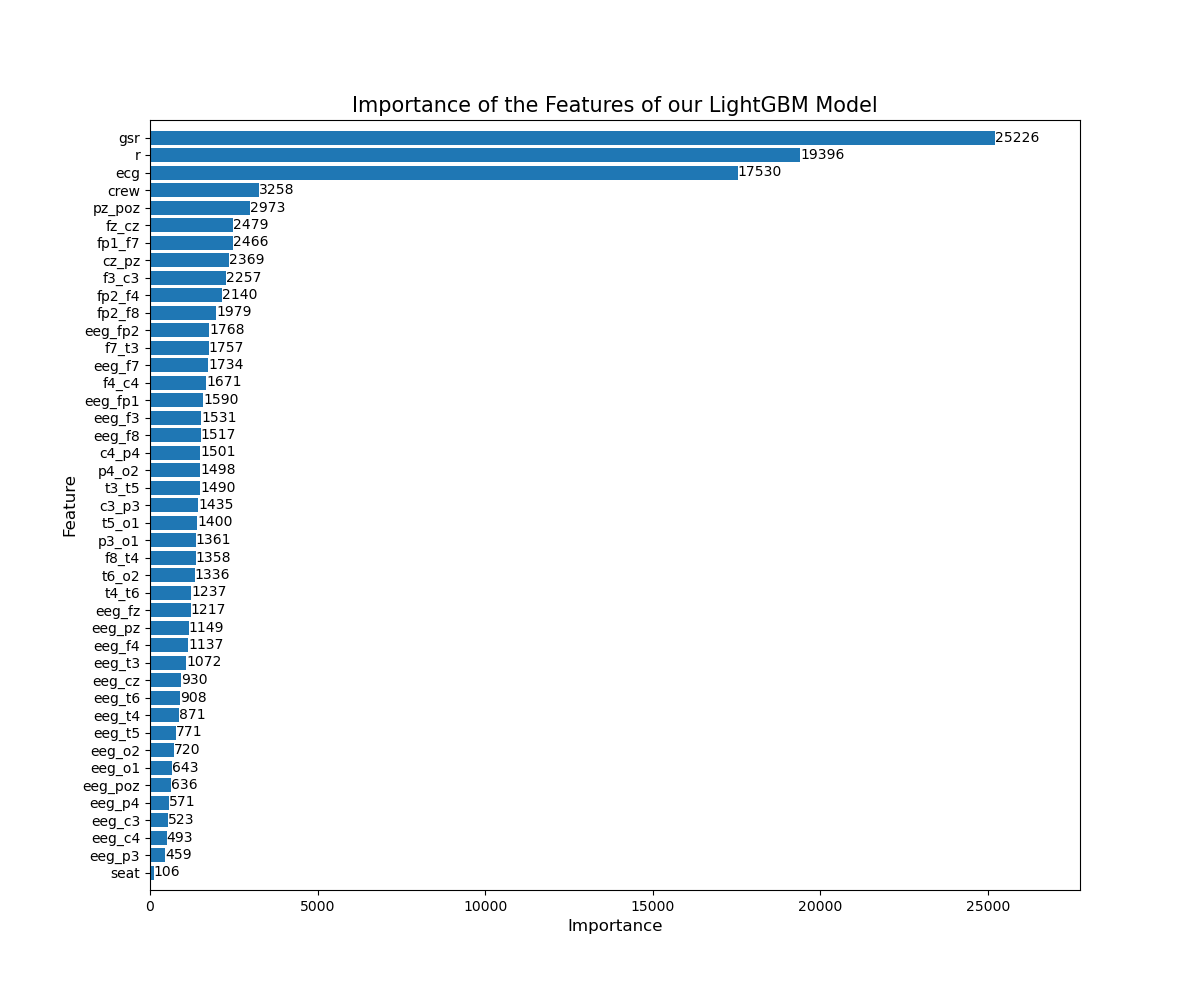

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
lightgbm.plot_importance(x_cfl, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

# Test

In [12]:
# filename = 'Lightlgb_model_003.sav'
# c_cfl = pickle.load(open(filename, 'rb'))

In [14]:
import pandas as pd
test_df =reduce_mem_usage(pd.read_csv("test.csv"))

Memory usage of dataframe is 3837.77MB
Memory usage after optimization is: 942.31MB
Decreased by 75.4%


In [15]:
test_df.drop(columns=['id','experiment','time'],axis=1,inplace=True)

In [16]:
test_df.head()

,crew,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,0,17.906250,6.128906,0.994629,-28.203125,-47.687500,-187.125000,-33.187500,-4.222656,...,-7.042969,-14.406250,-4.035156,-0.393799,31.843750,17.078125,-8.140625,-7324.0,643.0,595.00
1,1,1,45.875000,94.750000,23.296875,1.391602,2.060547,-5.144531,6.394531,33.406250,...,19.890625,-215.125000,2.119141,7.339844,9.664062,1169.000000,-0.024414,-3336.0,826.5,136.25
2,1,0,33.125000,28.359375,-7.238281,-7.691406,-25.828125,-107.250000,12.843750,1.214844,...,-7.640625,-10.367188,10.953125,6.511719,36.031250,24.359375,0.956055,-7324.0,643.0,595.00
3,1,1,43.281250,95.875000,18.703125,-1.432617,-4.234375,-8.023438,7.425781,27.343750,...,13.828125,-214.250000,-4.914062,3.503906,3.878906,1159.000000,-0.047607,-3336.0,826.5,136.25
4,1,0,7.929688,3.460938,-10.859375,-26.359375,-25.890625,37.000000,-50.343750,-11.679688,...,2.044922,-20.781250,-3.613281,-7.539062,3.083984,13.648438,1.473633,-7324.0,643.0,595.00


In [17]:
test_df['fp1_f7'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f7_t3'] = test_df['eeg_f7'] - test_df['eeg_t3']
test_df['t3_t5'] = test_df['eeg_t3'] - test_df['eeg_t5']
test_df['t5_o1'] = test_df['eeg_t5'] - test_df['eeg_o1']
test_df['fp1_f3'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f3_c3'] = test_df['eeg_f3'] - test_df['eeg_c3']
test_df['c3_p3'] = test_df['eeg_c3'] - test_df['eeg_p3']
test_df['p3_o1'] = test_df['eeg_p3'] - test_df['eeg_o1']

test_df['fz_cz'] = test_df['eeg_fz'] - test_df['eeg_cz']
test_df['cz_pz'] = test_df['eeg_cz'] - test_df['eeg_pz']
test_df['pz_poz'] = test_df['eeg_pz'] - test_df['eeg_poz']

test_df['fp2_f8'] = test_df['eeg_fp2'] - test_df['eeg_f8']
test_df['f8_t4'] = test_df['eeg_f8'] - test_df['eeg_t4']
test_df['t4_t6'] = test_df['eeg_t4'] - test_df['eeg_t6']
test_df['t6_o2'] = test_df['eeg_t6'] - test_df['eeg_o2']
test_df['fp2_f4'] = test_df['eeg_fp2'] - test_df['eeg_f4']
test_df['f4_c4'] = test_df['eeg_f4'] - test_df['eeg_c4']
test_df['c4_p4'] = test_df['eeg_c4'] - test_df['eeg_p4']
test_df['p4_o2'] = test_df['eeg_p4'] - test_df['eeg_o2']

In [18]:
test_df.shape

(17965143, 44)

In [21]:
predict_test_y = sig_clf.predict_proba(test_df[:1])
predict_test_y

array([[0.97343671, 0.00115949, 0.01771657, 0.00768723]])

In [22]:
predict_test_y = sig_clf.predict_proba(test_df)

In [23]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], predict_test_y), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [24]:
submission.to_csv("submission_random_forest.csv", index=False)

In [17]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ["Model",'train log loss','Test log loss']
ptable.add_row(["Random Model ", "-","1.6449"])
ptable.add_row(["Logistic Regression ", "0.65754","0.657494"])
ptable.add_row(["Random Forest","0.00344","0.027255"])
ptable.add_row(["LightGBM","0.27559","0.27585"])
print(ptable)

+----------------------+----------------+---------------+
|        Model         | train log loss | Test log loss |
+----------------------+----------------+---------------+
|    Random Model      |       -        |     1.6449    |
| Logistic Regression  |    0.65754     |    0.657494   |
|    Random Forest     |    0.00344     |    0.027255   |
|       LightGBM       |    0.27559     |    0.27585    |
+----------------------+----------------+---------------+


# Meta Learning

In [4]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
0,1,1,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,...,-7.871094,-15.281250,2.832031,3.265625,-29.515625,2.210938,-9.789062,-34.281250,19.937500,2.929688
1,1,1,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,...,-4.136719,-14.218750,2.849609,-5.566406,-19.718750,-1.781250,-13.578125,-24.062500,11.773438,1.649414
2,1,1,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,...,-7.039062,-14.593750,-15.437500,-9.375000,8.578125,-6.105469,-12.796875,24.718750,-31.406250,-2.851562
3,1,1,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,...,-6.097656,-14.000000,-2.689453,-9.976562,-8.117188,1.535156,-11.718750,-7.113281,-4.582031,4.156250
4,1,1,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,...,-10.796875,-10.171875,-2.066406,-5.632812,-14.085938,-2.978516,-9.960938,1.452148,-16.203125,-0.058105


In [5]:
y_true = train_df['event']
train_df.drop(columns=['event','experiment','time'],inplace=True)

In [6]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(train_df, y_true,stratify=y_true,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [7]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in CV data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7292950, 44)
Number of data points in CV data : (1823238, 44)
Number of data points in test data : (2279048, 44)


In [8]:
X1_train = X_train[:3646475]
y1_train  =y_train[:3646475]
X2_train = X_train[3646475:]
y2_train  =y_train[3646475:]

In [11]:
print(X1_train.shape[0],y1_train.shape[0])
print(X2_train.shape[0],y2_train.shape[0])

3646475 3646475
3646475 3646475


we are taking only X1_train only

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini',class_weight='balanced')
parameters = {'max_depth' :[5, 10,15, 20,50],
 'min_samples_split':[2, 10, 100, 500] }
clf = RandomizedSearchCV(clf,parameters,cv=5,n_jobs=-1)
clf.fit(X1_train,y1_train)
print(clf.best_estimator_)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
    

In [ ]:
print(clf.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
data = pd.concat([X1_train, y1_train], axis=1, sort=False)
tree_model = dict()
prob_model = dict()
all_data = pd.DataFrame()
for i in range(10):
    sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(100000,replace=True))
    sample_y = sample['event']
    sample.drop(columns=['event'],axis=1,inplace=True)
    clf = DecisionTreeClassifier(criterion='gini',max_depth=50,min_samples_split=2,class_weight='balanced')
    clf.fit(sample,sample_y)
    tree_model[i]=clf
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sample,sample_y)
    prob_model[i] = sig_clf
    print("Model No : {} is complated".format(i+1))
    del sample,sample_y,clf,sig_clf

Model No : 1 is complated
Model No : 2 is complated
Model No : 3 is complated
Model No : 4 is complated
Model No : 5 is complated
Model No : 6 is complated
Model No : 7 is complated
Model No : 8 is complated
Model No : 9 is complated
Model No : 10 is complated


In [ ]:
# all_data.to_csv("/gdrive/My Drive/Meta_learning.csv",index=False)
filename = 'Models/meta-Learning_tree_model.sav'
pickle.dump(tree_model, open(filename, 'wb'))
filename = 'Models/meta-Learning_prob_model.sav'
pickle.dump(prob_model, open(filename, 'wb'))

In [ ]:
import gc
gc.collect()

325

## Taking 2nd Part of X_train

In [ ]:
data = pd.concat([X2_train, y2_train], axis=1, sort=False)
sample = data.groupby('event', group_keys=False).apply(lambda data: data.sample(50000,replace=True))
sample_y = sample['event']
sample.drop(columns=['event'],axis=1,inplace=True)
all_data = []
for i in range(10):
    sig_clf =prob_model[i]
    column = [x+"_"+str(i) for x in list('ABCD')]
    y_predict = pd.DataFrame(sig_clf.predict_proba(sample),columns=column)
    all_data.append(y_predict)
    print("Model No : {} is complated".format(i+1))
    del y_predict
    gc.collect()

Model No : 1 is complated
Model No : 2 is complated
Model No : 3 is complated
Model No : 4 is complated
Model No : 5 is complated
Model No : 6 is complated
Model No : 7 is complated
Model No : 8 is complated
Model No : 9 is complated
Model No : 10 is complated


In [ ]:
data =pd.concat([all_data[0],all_data[1],all_data[2],all_data[3],all_data[4],all_data[5],all_data[6],all_data[7],all_data[8],all_data[9]],axis=1)
data['y_true'] = sample_y.values
data.head()

,A_0,B_0,C_0,D_0,A_1,B_1,C_1,D_1,A_2,B_2,C_2,D_2,A_3,B_3,C_3,D_3,A_4,B_4,C_4,D_4,A_5,B_5,C_5,D_5,A_6,B_6,C_6,D_6,A_7,B_7,C_7,D_7,A_8,B_8,C_8,D_8,A_9,B_9,C_9,D_9,y_true
199995,0.052707,0.006974,0.005518,0.934800,0.050385,0.007125,0.005838,0.936653,0.231176,0.006945,0.005849,0.756030,0.051570,0.007500,0.005665,0.935265,0.050843,0.006990,0.005850,0.936317,0.049746,0.007088,0.006001,0.937164,0.050562,0.006908,0.005809,0.936721,0.230536,0.007007,0.005777,0.756680,0.050395,0.006862,0.005693,0.937050,0.050957,0.006978,0.005235,0.936830,4.0
199996,0.412208,0.007069,0.005592,0.575131,0.230213,0.007175,0.005880,0.756732,0.411328,0.006984,0.005882,0.575806,0.591635,0.007663,0.005790,0.394912,0.411210,0.007084,0.005928,0.575779,0.230574,0.007140,0.006040,0.756246,0.411181,0.007006,0.005889,0.575924,0.230402,0.007000,0.005774,0.756823,0.050395,0.006862,0.005693,0.937050,0.231407,0.007020,0.005271,0.756303,4.0
199997,0.052707,0.006974,0.005518,0.934800,0.050385,0.007125,0.005838,0.936653,0.050856,0.006895,0.005804,0.936445,0.051570,0.007500,0.005665,0.935265,0.050843,0.006990,0.005850,0.936317,0.049746,0.007088,0.006001,0.937164,0.050562,0.006908,0.005809,0.936721,0.049819,0.006953,0.005732,0.937496,0.050395,0.006862,0.005693,0.937050,0.050957,0.006978,0.005235,0.936830,4.0
199998,0.411662,0.007064,0.005591,0.575683,0.230693,0.007174,0.005880,0.756254,0.050856,0.006895,0.005804,0.936445,0.051570,0.007500,0.005665,0.935265,0.050843,0.006990,0.005850,0.936317,0.049746,0.007088,0.006001,0.937164,0.412071,0.007002,0.005889,0.575038,0.049819,0.006953,0.005732,0.937496,0.230282,0.006909,0.005738,0.757071,0.050957,0.006978,0.005235,0.936830,4.0
199999,0.411598,0.007063,0.005595,0.575744,0.230213,0.007175,0.005880,0.756732,0.050856,0.006895,0.005804,0.936445,0.590827,0.007667,0.005787,0.395719,0.050843,0.006990,0.005850,0.936317,0.230574,0.007140,0.006040,0.756246,0.050562,0.006908,0.005809,0.936721,0.230536,0.007007,0.005777,0.756680,0.231022,0.006902,0.005728,0.756348,0.952589,0.007218,0.005416,0.034777,4.0


In [ ]:
print("Task is completed til now ")

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

In [ ]:
meta_y= data['y_true']
meta_x= data.drop(columns=['y_true']) 

In [ ]:
from lightgbm import LGBMClassifier
x_cfl=LGBMClassifier()

prams={
    'learning_rate':[0.01,0.05,0.1,0.15],
     'n_estimators':[100,200,500,1000,1500],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.1,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(meta_x, meta_y)
print(random_cfl.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 67.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 72.8min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
               importance_type='split', learning_rate=0.05, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.1, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
random_cfl.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 1500,
 'subsample': 0.1}

In [ ]:
subsample = random_cfl.best_params_['subsample']
n_estimators=  random_cfl.best_params_['n_estimators']
max_depth =  random_cfl.best_params_['max_depth']
learning_rate =  random_cfl.best_params_['learning_rate']
colsample_bytree =  random_cfl.best_params_['colsample_bytree']

In [ ]:
x_cfl=LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, colsample_bytree= colsample_bytree, max_depth=max_depth,subsample=subsample,n_jobs=-1,)
x_cfl.fit(meta_x,meta_y)

c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(meta_x,meta_y)

predict_y = c_cfl.predict_proba(meta_x)
print ('train loss',log_loss(meta_y, predict_y))

train loss 0.03526234637784663


In [9]:
prob_model  = pickle.load(open("Models/meta-Learning_prob_model.sav", 'rb')) 
final_model  = pickle.load(open("Models/meta-final_model.sav", 'rb')) 

In [ ]:
X_test.shape

(2279048, 44)

In [ ]:
import gc

In [10]:
all_data=[]
for i in range(10):
    sig_clf =prob_model[i]
    column = [x+"_"+str(i) for x in list('ABCD')]
    y_predict = pd.DataFrame(sig_clf.predict_proba(X_test),columns=column)
    all_data.append(y_predict)
    print("Model No : {} is complated".format(i+1))
    del y_predict

Model No : 1 is complated
Model No : 2 is complated
Model No : 3 is complated
Model No : 4 is complated
Model No : 5 is complated
Model No : 6 is complated
Model No : 7 is complated
Model No : 8 is complated
Model No : 9 is complated
Model No : 10 is complated


In [ ]:
y_test.shape

(2279048,)

In [11]:
x_test_data =pd.concat([all_data[0],all_data[1],all_data[2],all_data[3],all_data[4],all_data[5],all_data[6],all_data[7],all_data[8],all_data[9]],axis=1)

In [14]:
predict_y = final_model.predict_proba(x_test_data)
print ('log loss for test data',log_loss(y_test, predict_y, eps=1e-15))

log loss for test data 0.10343578848903372


Number of misclassified points 2.694502265858376 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


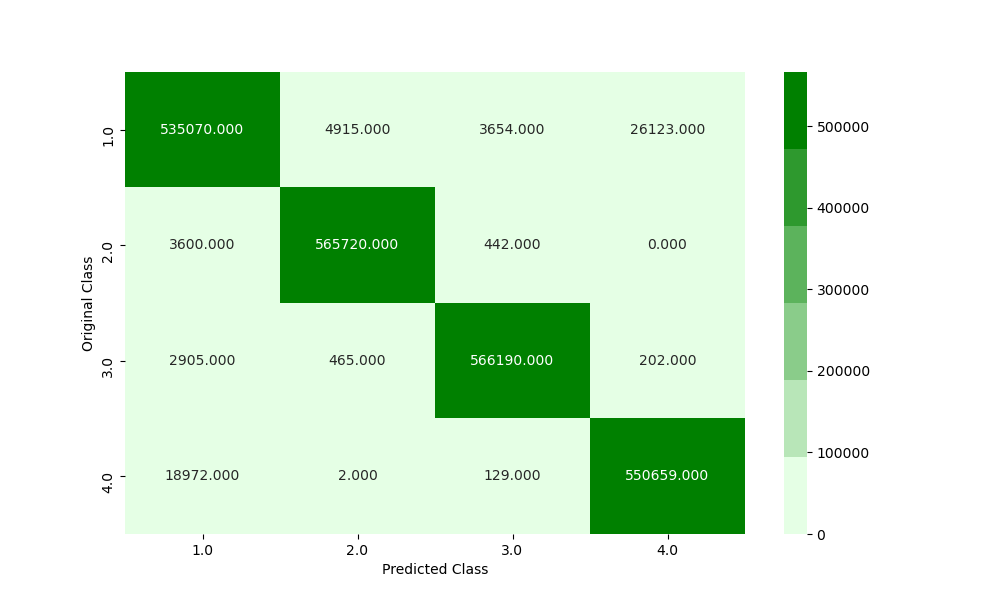

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


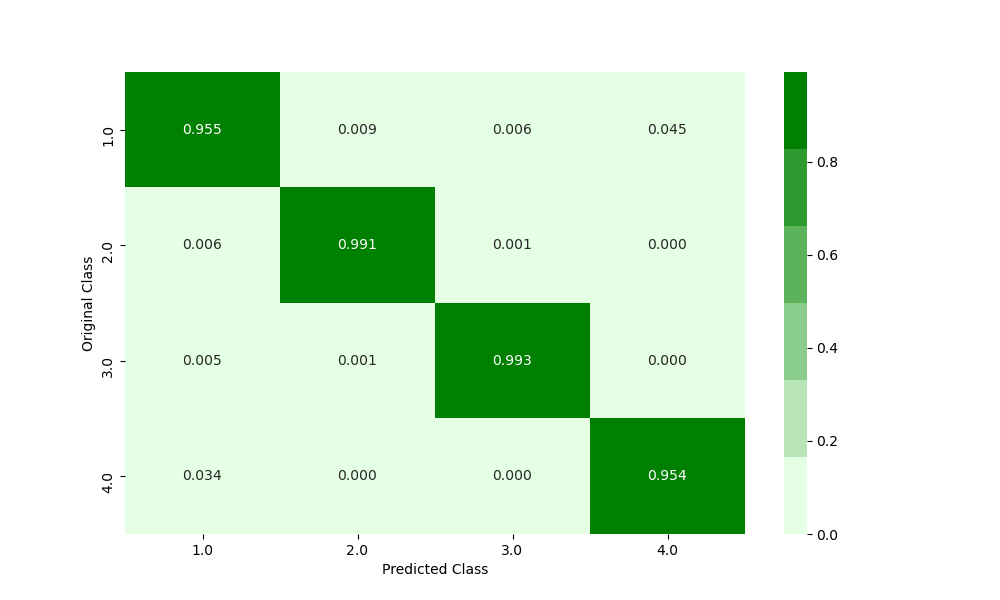

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


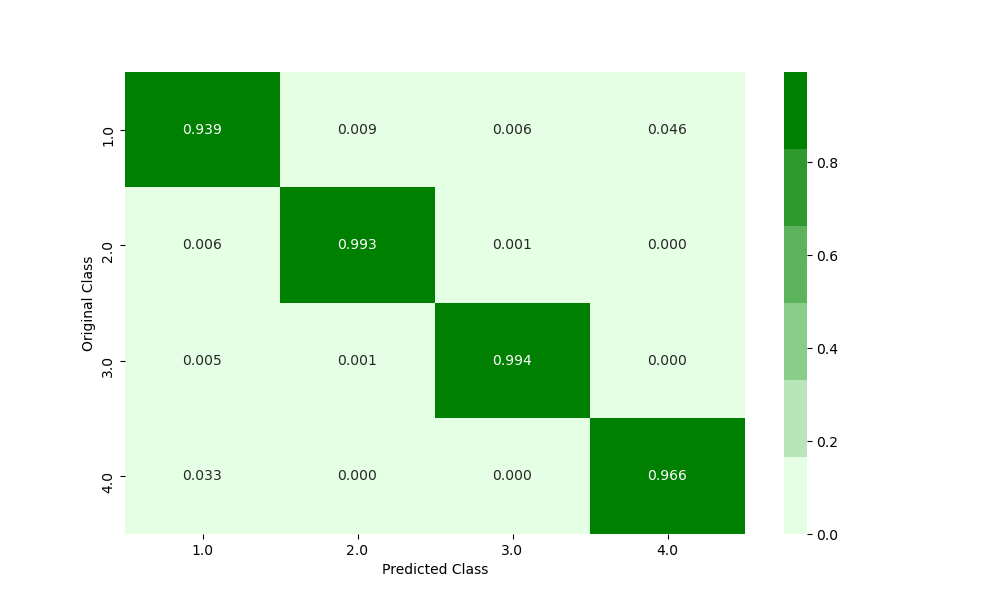

Sum of rows in precision matrix [1. 1. 1. 1.]


In [12]:

predict_y_test=final_model.predict(x_test_data)
plot_confusion_matrix(y_test,predict_y_test)

# Meta- Learning Function 

In [ ]:
train_df = reduce_mem_usage(pd.read_csv("train.csv"))

In [ ]:
test_df = reduce_mem_usage(pd.read_csv("test.csv"))

In [4]:
event_encode= {'A':0,'B':1,'C':2,'D':3}
train_df['event'] = train_df['event'].apply(lambda x: event_encode[x])
experiment_encode= {'CA':0,'DA':1,'SS':2,'LOFT':3}
train_df['experiment'] = train_df['experiment'].apply(lambda x: experiment_encode[x])
train_df['experiment'] = train_df['experiment'].astype('int8')

In [5]:
y_true = train_df['event']
train_df.drop(columns=['event'],inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_true,test_size=0.25,shuffle=False)

In [ ]:
def custom_ensemble(X_train,y_train,X_test,n_estimators):
    import gc
    import lightgbm as lgb
    train_data = pd.concat([X_train, y_train], axis=1, sort=False)

    divide = int(train_data.shape[0]/2)    
    X1_train = train_data[:divide]
    X2_train = train_data[divide:]

    tree_model = dict()
    prob_model = dict()
    for i in range(n_estimators):
        if (i%10==0):
            print("Training on Model No : ",i)
        sample = X1_train.groupby('event', group_keys=False).apply(lambda X1_train: X1_train.sample(100000,replace=True))
        sample_y = sample['event']
        sample.drop(columns=['event'],axis=1,inplace=True)
        clf = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_split=2,class_weight='balanced')
        clf.fit(sample,sample_y)
        tree_model[i]=clf
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(sample,sample_y)
        prob_model[i] = sig_clf
        del sample,sample_y
        gc.collect()
    pickle.dump(prob_model,open("Proba_model.sav",'wb'))
    pickle.dump(tree_model,open("Tree_model.sav",'wb'))
    print("------------------------------------------------------------------------------------------")
    print("Training First Part is completed")
    #X2_train
    all_data = pd.DataFrame()
    X2_y_true = X2_train['event']
    X2_train.drop(columns=['event'],inplace=True,axis=1)
    for i in range(n_estimators):
        if (i%10==0):
            print("preparing for Model data no : ",i)
        sig_clf =prob_model[i]
        column = [x+"_"+str(i) for x in list('ABCD')]
        y_predict = pd.DataFrame(sig_clf.predict_proba(X2_train),columns=column)
        all_data = pd.concat([all_data,y_predict],axis=1)
        del y_predict,sig_clf
        gc.collect()
    print("Training Second Part is completed")

    params = {
        "objective" : "multiclass", # used for multiclass softmax classifier
        "metric" : "multi_error",   # Error rate for multiclass classification 
        "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
        'num_class':4,              # Number of desired output classes is 4 
        "num_leaves" : 10,          # Number of leaves in Tree based algorithms
        "learning_rate" : 0.01,     
        "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                                    # it will decrease impact of high variance on data
        "bagging_seed" : 0,         # Random seeds for bagging
        "num_threads" : 4,
        "colsample_bytree" : 0.5,   # Subsampling fraction for feature
        'min_data_in_leaf':100,     # Threshold on Data in a leaf
        'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
          }
    X2_y_true=X2_y_true.astype('int8')
    xg_train = lgb.Dataset(all_data, label=X2_y_true)
    model = lgb.train(  params, 
                      train_set = xg_train,
                      num_boost_round=2000,
                      early_stopping_rounds=200,
                      verbose_eval=1, 
                      valid_sets=[xg_train]
                    )
    pickle.dump(model,open("LightGBM_Model.sav",'wb'))
    print("Model Training is Completed")
    print("-"*50)
    print("Test Prediction is Started")
    all_data = pd.DataFrame()
    experiment_encode= {'CA':0,'DA':1,'SS':2,'LOFT':3}
    X_test['experiment'] = X_test['experiment'].apply(lambda x: experiment_encode[x])
    X_test['experiment'] = X_test['experiment'].astype('int8')
    for i in range(n_estimators):
        sig_clf =prob_model[i]
        column = [x+"_"+str(i) for x in list('ABCD')]
        y_predict = pd.DataFrame(sig_clf.predict_proba(X_test),columns=column)
        all_data = pd.concat([all_data,y_predict],axis=1)
        del y_predict,sig_clf
        gc.collect()
    prediction = model.predict(all_data)
    print("Test Prediction is complted")
    return prediction

In [ ]:
prediction = custom_ensemble(X_train,y_train,test_df,n_estimators=50)

In [ ]:
submission = pd.DataFrame(np.concatenate((np.arange(len(prediction))[:, np.newaxis], prediction), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [ ]:
submission.to_csv("submission_MetaLearing_50.csv", index=False)

In [ ]:
!tar chvfz submission_meta_learning_50.tar.gz "submission_MetaLearing_50.csv"

# LightGBM with time and Experiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_true,test_size=0.25,shuffle=False)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (3650565, 27)
Number of data points in test data : (1216856, 27)


In [ ]:
y_train.unique()

[0, 2, 3, 1]
Categories (4, int64): [0, 2, 3, 1]

In [ ]:
import lightgbm as lgb
params = {
          "objective" : "multiclass", # used for multiclass softmax classifier
          "metric" : "multi_error",   # Error rate for multiclass classification 
          "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
          'num_class':4,              # Number of desired output classes is 4 
          "num_leaves" : 30,          # Number of leaves in Tree based algorithms
          "learning_rate" : 0.01,     
          "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                                      # it will decrease impact of high variance on data
          "bagging_seed" : 0,         # Random seeds for bagging
          "num_threads" : 4,
          "colsample_bytree" : 0.5,   # Subsampling fraction for feature
          'min_data_in_leaf':100,     # Threshold on Data in a leaf
          'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
            }
xg_train = lgb.Dataset(X_train, label=y_train)
xg_test = lgb.Dataset(X_test, label=y_test)

model = lgb.train(  params, 
                      train_set = xg_train,
                      num_boost_round=2000,
                      early_stopping_rounds=200,
                      verbose_eval=1, 
                      valid_sets=[xg_train,xg_test]
                    )

[1]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
Training until validation scores don't improve for 200 rounds.
[2]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[3]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[4]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[5]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[6]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[7]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[8]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[9]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[10]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[11]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[12]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[13]	training's multi_error: 0.42435	valid_1's multi_error: 0.385827
[14]	training's multi_error: 0.42435	valid_1's mu

In [ ]:
pickle.dump(model,open("/content/lgb_23_sep_01.sav",'wb'))

In [ ]:
prediction = model.predict(X_test)

In [ ]:
predict = np.argmax(prediction,axis=1)

Number of misclassified points 8.106628886244552 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


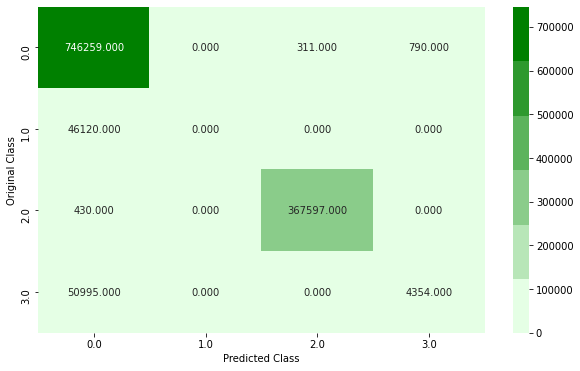

-------------------------------------------------- Precision matrix --------------------------------------------------


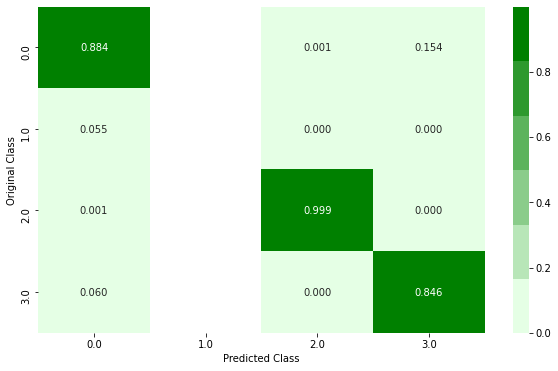

Sum of columns in precision matrix [ 1. nan  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


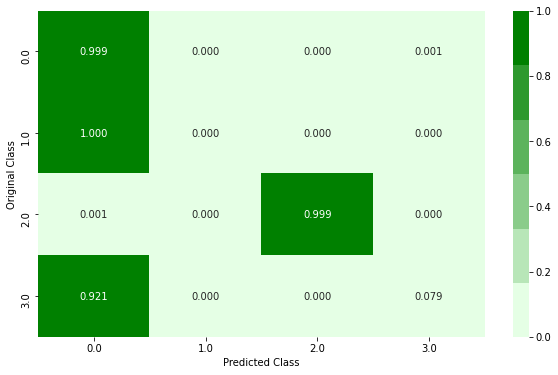

Sum of rows in precision matrix [1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(y_test,predict)

In [ ]:
print("Log loss on Test Data  Model",log_loss(y_test, prediction, eps=1e-15))

Log loss on Test Data  Model 0.2906665226789483


In [ ]:
test_df = reduce_mem_usage(pd.read_csv("test.csv"))

In [ ]:
test_df.drop(columns=['id'],axis=0,inplace=True)
experiment_encode= {'CA':0,'DA':1,'SS':2,'LOFT':3}
test_df['experiment'] = test_df['experiment'].apply(lambda x: experiment_encode[x])
test_df['experiment'] = test_df['experiment'].astype('int8')

In [ ]:
pred_prob = model.predict(test_df)

In [ ]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_data))[:, np.newaxis], test_data), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [ ]:
submission.to_csv("submission_improve_LGB.csv", index=False)

In [4]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ["Model",'train log loss','Test log loss']
ptable.add_row(["Random Model ", "-","1.6449"])
ptable.add_row(["Logistic Regression ", "0.65754","0.657494"])
ptable.add_row(["Random Forest","0.00344","0.027255"])
ptable.add_row(["LightGBM","0.27559","0.27585"])
ptable.add_row(["Meta Learning","0.0352","0.1034"])
ptable.add_row(["Meta Learning_50 with Time and Experiment without suffle","--","0.1726"])
ptable.add_row(["LightGBM with Time and Experiment without suffle ","--","0.2906"])

print(ptable)

+----------------------------------------------------------+----------------+---------------+
|                          Model                           | train log loss | Test log loss |
+----------------------------------------------------------+----------------+---------------+
|                      Random Model                        |       -        |     1.6449    |
|                   Logistic Regression                    |    0.65754     |    0.657494   |
|                      Random Forest                       |    0.00344     |    0.027255   |
|                         LightGBM                         |    0.27559     |    0.27585    |
|                      Meta Learning                       |     0.0352     |     0.1034    |
| Meta Learning_50 with Time and Experiment without suffle |       --       |     0.1726    |
|    LightGBM with Time and Experiment without suffle      |       --       |     0.2906    |
+----------------------------------------------------------+

Here are below observation from multiple submission
1. As we have seen in EDA time and experiment are different from test data in training so we train our model but result not up to mark 
2. In EDA part we have seen our data is imbalanced so we made data balanced using oversampling but still kaggle result we found lesser
3. Basically we are doing shuffle to split train and test data to train model but we observe that when we are not shuffle data it is giving better result on Kaggle score.
4. So at the end we have taken imbalanced data with time and experiment column, without shuffling train and test data so we found result about 0.31578 which best from all score I have submitted in Kaggle.
5. 0.31578 score is top 6 result in kaggle

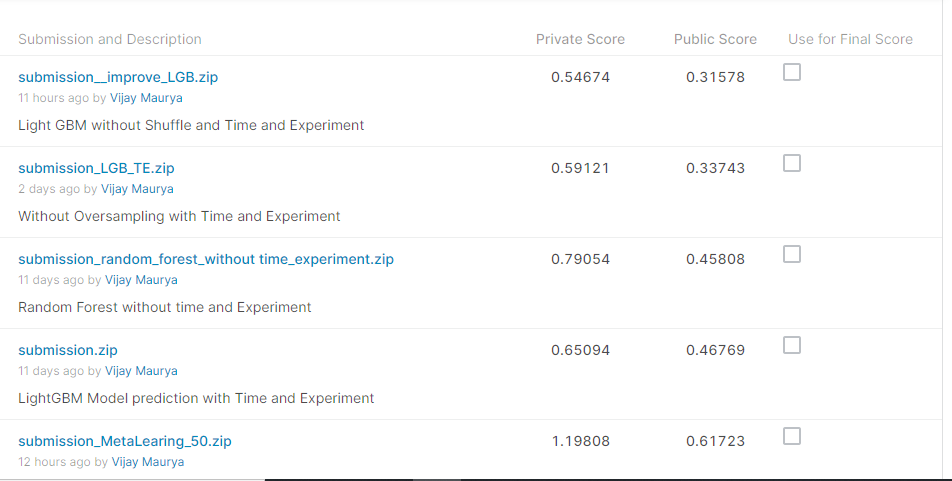

In [58]:
X  = pd.read_csv("Sample_X.csv")
y=X['event']
X.drop(columns=['event'],axis=1,inplace=True)

# Function for Production

In [77]:
def function1(X):
     #converting data into numpy array
    if(type(X)=='pandas.core.frame.DataFrame'):
        X = X.to_numpy()
    else:
        X = np.array(X)
        
    if(X.shape[1]!=27):
        return "27 featurs are required for prediction"
    experiment_encode= {'CA':0,'DA':1,'SS':2,'LOFT':3}
    X[0][1] =experiment_encode[X[0][1]]
    #loading Best Model
    model = pickle.load(open("LightGBM_best.sav","rb"))
    event_encode= {0:'A',1:'B',2:'C',3:'D'}
    return event_encode[np.argmax(model.predict(X))]
result =  final(data)
print("Model has predicted Event : ",result)

Model has predicted Event :  A


In [24]:
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix
def function2(X,y):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
  event_encode= {'A':0,'B':1,'C':2,'D':3}
  y = y.apply(lambda x: event_encode[x])
  experiment_encode= {'CA':0,'DA':1,'SS':2,'LOFT':3}
  # X['experiment'] = X['experiment'].apply(lambda x: experiment_encode[x])
  # X['experiment'] = X['experiment'].astype('int8')
  model = pickle.load(open("LightGBM_best.sav","rb"))
  predict_y_proba = model.predict(X)
  predict_y  = np.argmax(predict_y_proba,axis=1)
  print("Accurcy score of model",accuracy_score(y,predict_y))
  print("Log loss of  Model",log_loss(y, predict_y_proba))
  print(confusion_matrix(y,predict_y))
    
function2(train_df,y_true)   

Accurcy score of model 0.9505395156901365
Log loss of  Model 0.17548799084282016
[[2841552     826    2024    4407]
 [  49159   81438       0       0]
 [    443       0 1652243       0]
 [ 183886       0       0   51443]]
